In [ ]:
import numpy as np
from sklearn.utils import shuffle
from pickle import dump
import os
from tqdm import tqdm
import string
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from datetime import datetime as dt
import numpy as np
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, concatenate, RepeatVector, TimeDistributed, Bidirectional, Flatten
from nltk.translate.bleu_score import corpus_bleu
from keras.applications.xception import Xception
import numpy as np
import random
from keras.preprocessing.sequence import pad_sequences
#from utils.preprocessing import *
from pickle import load, dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from pickle import load
import matplotlib.pyplot as plt
import argparse
from keras.models import load_model
from PIL import Image
from keras.layers.merge import add
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def cnn(model_selection):
  if model_selection == 'inceptionv3':
      model = InceptionV3()
  if model_selection == 'vgg16':
      model = VGG16()
  elif model_selection == 'Xception':
      model = Xception()
  new_model = Model(model.input, model.layers[-2].output)
  return new_model

In [ ]:
def features_extraction(path, model_selection):
    if model_selection == 'inceptionv3':
        from keras.applications.inception_v3 import preprocess_input
        size = (299, 299)
    elif model_selection == 'vgg16':
        from keras.applications.vgg16 import preprocess_input
        size = (224, 224)
    elif model_selection == 'Xception':
        from keras.applications.xception import preprocess_input
        size = (299,299)
    model = cnn(model_selection)
    features = dict()
    for name in tqdm(os.listdir(path)):
        filename = path + name
        img = load_img(filename, target_size=size)
        img = image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        img_id = name.split('.')[0]
        feature = np.reshape(feature,feature.shape[1])
        features[img_id] = feature
    return features

In [ ]:
def rnn(vocab_size, max_len, model_config, model_selection):
    embedding_size = model_config['embeddingsize']
    if model_selection == 'inceptionv3':
        input_image = Input(shape=(2048,))
    elif model_selection == 'Xception':
        input_image = Input(shape=(2048,))
    im = Dropout(model_config['dropout'])(input_image)
    image = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(im)

    input_caption = Input(shape=(max_len,))
    cm1 = Embedding(vocab_size, embedding_size, mask_zero=True)(input_caption)
    cm2 = Dropout(model_config['dropout'])(cm1)
    caption = LSTM(model_config['lstm'])(cm2)

    

    decoder1 = concatenate([image, caption])
    decoder2 = Dense(model_config['dense'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder1)
    output_model = Dense(vocab_size, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=output_model)
    return model


In [ ]:
def AlternativeRNNModel(vocab_size, max_len, model_config, model_selection):
    embedding_size = model_config['embeddingsize']
    if model_selection == 'inceptionv3':
        input_image = Input(shape=(2048,))
    elif model_selection == 'Xception':
        input_image = Input(shape=(2048,))
    im = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_image)
    image = RepeatVector(max_len)(im)

    input_caption = Input(shape=(max_len,))
    cm1 = Embedding(vocab_size, embedding_size, mask_zero=True)(input_caption)
    cm2 = LSTM(model_config['lstm'], return_sequences=True)(cm1)
    caption = TimeDistributed(Dense(embedding_size))(cm2)

    decoder1 = concatenate([image, caption])
    decoder2 = Bidirectional(LSTM(model_config['lstm'], return_sequences=False))(decoder1)
    decoder3 = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder2)
    decoder4 = Dropout(model_config['dropout'])(decoder3)
    output_model = Dense(vocab_size, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder4)
  
    model = Model(inputs=[input_image, input_caption], outputs=output_model)
    return model

In [ ]:
def generate_word_from_int(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_description(model, tokenizer, image, max_len):
    desp = 'startseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([desp])[0]
        seq = pad_sequences([seq], maxlen=max_len)
        pred = model.predict([image,seq], verbose=0)
        pred = np.argmax(pred)
        word = generate_word_from_int(pred, tokenizer)
        if word is None:
            break
        desp += ' ' + word
        if word == 'endseq':
            break
    return desp


def model_evaluation(model, tokenizer, images, captions, max_len, beam_index):
    actual, prediction = list(), list()
    for img_id, cap_list in tqdm(captions.items()):
        images[img_id] = images[img_id].reshape((1,2048))
        #pred = generate_description(model, tokenizer, images[img_id], max_len)
        pred = generate_caption_beam_search(model, tokenizer, images[img_id], max_len, beam_index = 3)
        truth = [caption.split() for caption in cap_list]
        actual.append(truth)
        prediction.append(pred.split())
    print('BLEU Scores :')
    print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
    print('BLEU-1: %f' % corpus_bleu(actual, prediction, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, prediction, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, prediction, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, prediction, weights=(0.25, 0.25, 0.25, 0.25)))

def model_evaluation_greedy_search(model, tokenizer, images, captions, max_len):
    actual, prediction = list(), list()
    for img_id, cap_list in tqdm(captions.items()):
        images[img_id] = images[img_id].reshape((1,2048))
        pred = generate_description(model, tokenizer, images[img_id], max_len)
        #pred = beam_search_predictions(model, images[img_id], max_len, beam_index = 3)
        truth = [caption.split() for caption in cap_list]
        actual.append(truth)
        prediction.append(pred.split())
    print('BLEU Scores :')
    print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
    print('BLEU-1: %f' % corpus_bleu(actual, prediction, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, prediction, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, prediction, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, prediction, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
def loading_captions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()

    caps = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        img_id, img_cap = tokens[0], tokens[1:]
        img_id = img_id.split('.')[0]
        img_cap = ' '.join(img_cap)
        if img_id not in caps:
            caps[img_id] = list()
        caps[img_id].append(img_cap)
    return caps

def text_cleaning(caps):
    table = str.maketrans('', '', string.punctuation)
    for key, cap_list in caps.items():
        for i in range(len(cap_list)):
            caption = cap_list[i]
            caption = caption.split()
            caption = [word.lower() for word in caption]
            caption = [w.translate(table) for w in caption]
            caption = [word for word in caption if len(word)>1]
            caption = [word for word in caption if word.isalpha()]
            cap_list[i] =  ' '.join(caption)
        caps[key]=cap_list
    return caps


def save_cleaned_texts(caps, filename):
    lines = list()
    for key, cap_list in caps.items():
        for caption in cap_list:
            lines.append(key + ' ' + caption)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
def Data_preprocessing(path1,path2,cap_path,model_selection):
    if os.path.exists(path1+'features_'+model_selection+'.pkl'):
        print('Features for images are already generated at the location {}'.format(path1+'features_'+model_selection+'.pkl'))
    else:
        print('Generating the image features')
        features = features_extraction(path2, model_selection)
        dump(features, open(path1+'features_'+model_selection+'.pkl', 'wb'))
        print('Features are saved')
    if os.path.exists(path1+'captions.txt'):
        print('Captions for the images are already generated at the location {}'.format(path1+'captions.txt'))
    else:
        descriptions = loading_captions(cap_path)
        print(type(descriptions))
        print(descriptions)
        descriptions=text_cleaning(descriptions)
        print(type(descriptions))
        print(descriptions)
        save_cleaned_texts(descriptions, path1+'captions.txt')
        print('Captions are successfully generated')

In [ ]:
captions_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr8k.token.txt"
descriptions = loading_captions(captions_path)
print(type(descriptions))
#print(descriptions)
descriptions=text_cleaning(descriptions)
#print(descriptions)
unique_vocab = set()
for key in descriptions.keys():
  [unique_vocab.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(unique_vocab))

<class 'dict'>
Original Vocabulary Size: 8763


In [ ]:
path_for_extracted_features_captions = "/content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/"
model_types=['inceptionv3','vgg16','Xception']
image_dataset_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flicker8k_Dataset/"
captions_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr8k.token.txt"

for i in range(len(model_types)):
    Data_preprocessing(path_for_extracted_features_captions,image_dataset_path,captions_path,model_types[i])

Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_inceptionv3.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt
Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_vgg16.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt
Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_Xception.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt


In [ ]:
def extract_img_ids(filename):
    f = open(filename, 'r')
    r = f.read()
    f.close()
    ids = list()
    for i in r.split('\n'):
        if len(i) < 1:
            continue
        img_id = i.split('.')[0]
        ids.append(img_id)
    return set(ids)

In [ ]:
def load_cleaned_descriptions(filename, ids):
    f = open(filename, 'r')
    doc = f.read()
    f.close()
    image_captions = dict()
    for line in doc.split('\n'):
        img_id_desp = line.split()
        img_id, img_cap = img_id_desp[0], img_id_desp[1:]
        if img_id in ids:
            if img_id not in image_captions:
                image_captions[img_id] = list()
            desp = 'startseq ' + ' '.join(img_cap) + ' endseq'
            image_captions[img_id].append(desp)
    return image_captions

In [ ]:
def load_features(filename, ids):
    img_features = load(open(filename, 'rb'))
    features = {i: img_features[i] for i in ids}
    return features

In [ ]:
def convert_to_list(desp):
    img_desp = list()
    for img_id in desp.keys():
        [img_desp.append(cap) for cap in desp[img_id]]
    return img_desp

In [ ]:
def tokenizing(desp):
    desp_list = convert_to_list(desp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desp_list)
    return tokenizer

In [ ]:
def maximum_length(desp):
    desp_list = convert_to_list(desp)
    return max(len(i.split()) for i in desp_list)

In [ ]:
def generate_seq_update(image_features, description, max_len, batch_size, vocab_size, tokenizer):
  X1, X2, y = list(), list(), list()
  count = 0
  while 1:
    for key, desp_list in description.items():
      count = count+1
      img_feature = image_features[key]
      for desp in desp_list:
        seq = tokenizer.texts_to_sequences([desp])[0]
        for i in range(1, len(seq)):
            input_seq, output_seq = seq[:i], seq[i]
            input_seq = pad_sequences([input_seq], maxlen=max_len)[0]
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            X1.append(img_feature)
            X2.append(input_seq)
            y.append(output_seq)
      if count == batch_size:
        X_train=[np.array(X1),np.array(X2)]
        Y_train=np.array(y)
        yield (X_train,Y_train)
        X1, X2, y = list(), list(), list()
        count=0

In [ ]:
def get_train_data(train_dataset_path,path1,model_selection):
    img_ids_train = extract_img_ids(train_dataset_path)
    desp_train = load_cleaned_descriptions(path1+'captions.txt', img_ids_train)
    #print(desp_train)
    img_features_train = load_features(path1+'features_'+model_selection+'.pkl', img_ids_train)
    if not os.path.exists(path1+'tokenizer.pkl'):
        tokenizer = tokenizing(desp_train)
        dump(tokenizer, open(path1+'tokenizer.pkl', 'wb'))
    max_len = maximum_length(desp_train)
    return img_features_train, desp_train, max_len

In [ ]:
def get_val_data(val_dataset_path,path1,model_selection):
    img_ids_val = extract_img_ids(val_dataset_path)
    desp_val = load_cleaned_descriptions(path1+'captions.txt', img_ids_val)
    img_features_val = load_features(path1+'features_'+model_selection+'.pkl', img_ids_val)
    return img_features_val, desp_val

In [ ]:
embeddings_index = {} 
f = open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/glove.6B.200d.txt", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
tokenizer = load(open(path_for_extracted_features_captions+'tokenizer.pkl', 'rb'))
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix.shape)

(7579, 200)


In [ ]:
train_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.trainImages.txt"
val_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.devImages.txt"
model_selection = "Xception"
train_features, train_captions, max_len = get_train_data(train_dataset,path_for_extracted_features_captions,model_selection)
val_features,val_captions = get_val_data(val_dataset,path_for_extracted_features_captions,model_selection)
print(train_features['10815824_2997e03d76'])

[0.02142421 0.1410758  0.09508835 ... 0.07635967 0.17963612 0.01355512]


In [ ]:
print(len(train_features),type(train_features))
print(len(val_features),type(val_features))
print(max_len)
print(train_captions['2513260012_03d33305cf'])

6000 <class 'dict'>
1000 <class 'dict'>
34
['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']


In [ ]:
model_config={'dropout':0.3, 'dense':256, 'lstm':256, 'embeddingsize':256}

In [ ]:
model = AlternativeRNNModel(vocab_size, max_len, model_config, model_selection)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

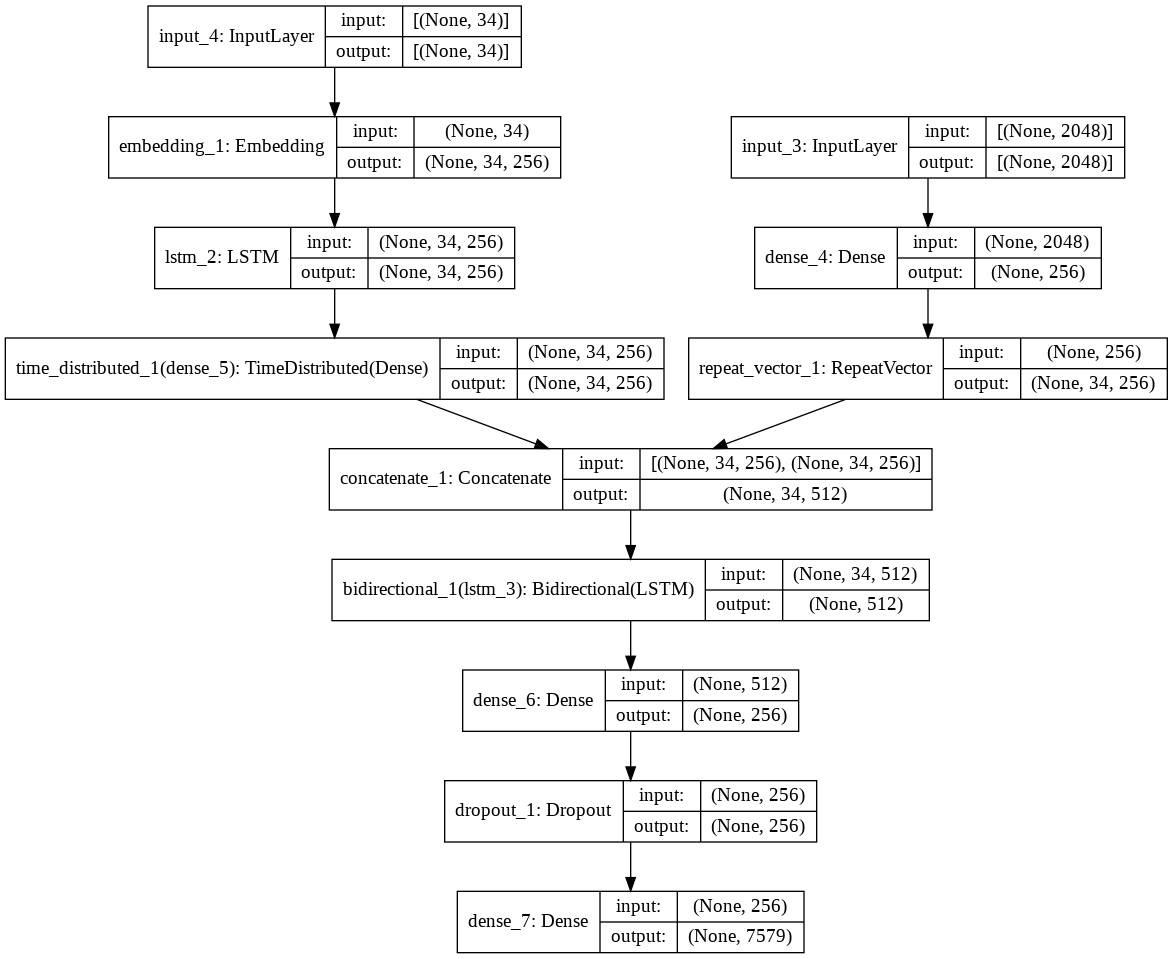

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
[a,b],c = next(generate_seq_update(train_features, train_captions, max_len, 1, vocab_size, tokenizer))
print(a.shape, b.shape, c.shape)
print(c)

(47, 2048) (47, 34) (47, 7579)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
print(model.summary())
print(len(train_features))
print(len(train_captions))
print(vocab_size)
print(max_len)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_7[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          524544      input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
batch_size = 3
train_steps = np.ceil(len(train_captions)/batch_size)
val_steps  = np.ceil(len(val_captions)/batch_size)
epochs=10
print(train_steps,val_steps)
model_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+'lstm_adam_with_tokenizer_with_embedding_last.hdf5'
#checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpointer = [checkpoint]
history_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+"lstm_adam_with_tokenizer_with_embedding_last"

2000.0 334.0


In [ ]:
train_data_generator = generate_seq_update(train_features, train_captions, max_len, batch_size, vocab_size, tokenizer)
val_data_generator = generate_seq_update(val_features, val_captions, max_len, batch_size, vocab_size, tokenizer)
history = model.fit(train_data_generator, epochs=epochs, steps_per_epoch = train_steps, validation_data=val_data_generator, validation_steps= val_steps, verbose=1)
model.save(model_save_path)
with open(history_save_path, 'wb') as file_pi:
  dump(history.history, file_pi)
print("Done with epoch ")
print('\n\n\n\n')

Epoch 1/10
2000/2000 [==============================] - 467s 228ms/step - loss: 6.4458 - accuracy: 0.1494 - val_loss: 5.2054 - val_accuracy: 0.2045
Epoch 2/10
2000/2000 [==============================] - 456s 228ms/step - loss: 5.1502 - accuracy: 0.2133 - val_loss: 5.0289 - val_accuracy: 0.2278
Epoch 3/10
2000/2000 [==============================] - 453s 226ms/step - loss: 4.9837 - accuracy: 0.2338 - val_loss: 4.9462 - val_accuracy: 0.2335
Epoch 4/10
2000/2000 [==============================] - 452s 226ms/step - loss: 4.8905 - accuracy: 0.2443 - val_loss: 4.8963 - val_accuracy: 0.2374
Epoch 5/10
2000/2000 [==============================] - 453s 226ms/step - loss: 4.8217 - accuracy: 0.2496 - val_loss: 4.8719 - val_accuracy: 0.2403
Epoch 6/10
2000/2000 [==============================] - 454s 227ms/step - loss: 4.7692 - accuracy: 0.2547 - val_loss: 4.8439 - val_accuracy: 0.2419
Epoch 7/10
2000/2000 [==============================] - 453s 226ms/step - loss: 4.7254 - accuracy: 0.2578 - val_

In [ ]:
'''used for extracting test features'''

def test_feature_extraction(path, model_selection):
    if model_selection == 'inceptionv3':
        from keras.applications.inception_v3 import preprocess_input
        size = (299, 299)
    elif model_selection == 'vgg16':
        from keras.applications.vgg16 import preprocess_input
        size = (224, 224)
    elif model_selection == 'Xception':
        from keras.applications.xception import preprocess_input
        size = (299,299)
    model = cnn(model_selection)
    features = dict()
    for name in tqdm(os.listdir(path)):
        filename = path + name
        img = load_img(filename, target_size=size)
        img = image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        img_id = name.split('.')[0]
        feature = np.reshape(feature,feature.shape[1])
    return feature

In [ ]:
def generate_caption_beam_search(model, tokenizer, image, max_length, beam_index=3):
	in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
	while len(in_text[0][0]) < max_length:
		tempList = []
		for seq in in_text:
			padded_seq = pad_sequences([seq[0]], maxlen=max_length)
			preds = model.predict([image,padded_seq], verbose=0)
			top_preds = np.argsort(preds[0])[-beam_index:]
			for word in top_preds:
				next_seq, prob = seq[0][:], seq[1]
				next_seq.append(word)
				prob += preds[0][word]
				tempList.append([next_seq, prob])
		in_text = tempList
		in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
		in_text = in_text[-beam_index:]
	in_text = in_text[-1][0]
	final_caption_raw = [generate_word_from_int(i,tokenizer) for i in in_text]
	final_caption = []
	for word in final_caption_raw:
		if word=='endseq':
			break
		else:
			final_caption.append(word)
	final_caption.append('endseq')
	return ' '.join(final_caption)

In [ ]:
test_data_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/"

100%|██████████| 1000/1000 [1:39:46<00:00,  5.99s/it]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.446448
BLEU-2: 0.171093
BLEU-3: 0.097733


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-4: 0.032105


100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.534115
BLEU-2: 0.233468
BLEU-3: 0.137831
BLEU-4: 0.054577
startseq man is sitting on the beach endseq
beam startseq man is sitting on rock endseq


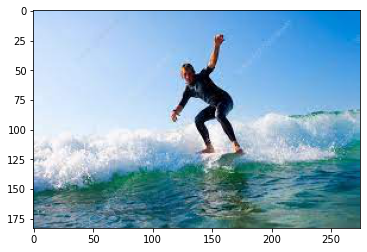

In [ ]:
max_len = 34

feature = test_feature_extraction(test_data_path, "Xception")
feature = feature.reshape((1,2048))
img = Image.open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/test1.jpg")


plt.imshow(img)
model_evaluation(model, tokenizer, val_features, val_captions, max_len, 3)
model_evaluation_greedy_search(model, tokenizer, val_features, val_captions, max_len)
description = generate_description(model, tokenizer, feature, max_len)
beam_descrption = generate_caption_beam_search(model, tokenizer, feature, max_len, 3)
print(description)
print("beam", beam_descrption) 

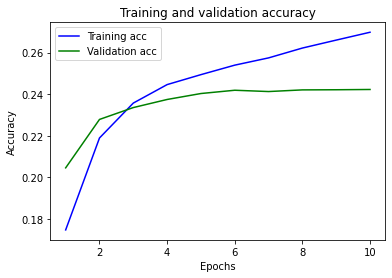

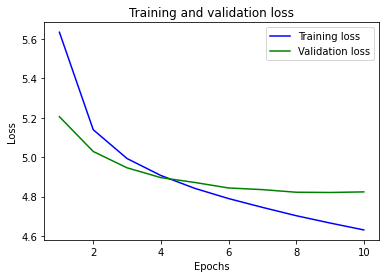

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()